# Tutorial For Recurrent Neural Network (RNN)

![RNN](RNN.png)
Image by author

A recurrent neural network (RNN) is the type of artificial neural network (ANN) that is used in Apple’s Siri and Google’s voice search. RNN remembers past inputs due to an internal memory which is useful for predicting stock prices, generating sentences, transcriptions, and machine translation.

In [1]:
# !pip install kaggle
# !kaggle datasets download -d kalilurrahman/mastercard-stock-data-latest-and-updated
# !unzip mastercard-stock-data-latest-and-updated -d ./data

The code is inspired from Siddgarth Yadav [Intro to RNN](https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru)

In this project, we are going to use Kaggle’s [MasterCard Stock Data](https://www.kaggle.com/kalilurrahman/mastercard-stock-data-latest-and-updated?select=Mastercard_stock_history.csv) from May-25-2006 to Oct-11-2021 and train the LSTM and GRU model to forecast the stock price. 

In [2]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)

## Data Analysis

Converting the `Date` column to DateTime format and adding it to index. Dropping irrelevant columns to make the final dataset cleaner.  

In [3]:
# First, we get the data
dataset = pd.read_csv(
    "data/Mastercard_stock_history.csv", index_col="Date", parse_dates=["Date"]
).drop(["Dividends", "Stock Splits"], axis=1)
print(dataset.head())


                Open      High       Low     Close     Volume
Date                                                         
2006-05-25  3.748967  4.283869  3.739664  4.279217  395343000
2006-05-26  4.307126  4.348058  4.103398  4.179680  103044000
2006-05-30  4.183400  4.184330  3.986184  4.093164   49898000
2006-05-31  4.125723  4.219679  4.125723  4.180608   30002000
2006-06-01  4.179678  4.474572  4.176887  4.419686   62344000


In [4]:
print(dataset.describe())

              Open         High          Low        Close        Volume
count  3872.000000  3872.000000  3872.000000  3872.000000  3.872000e+03
mean    104.896814   105.956054   103.769349   104.882714  1.232250e+07
std     106.245511   107.303589   105.050064   106.168693  1.759665e+07
min       3.748967     4.102467     3.739664     4.083861  6.411000e+05
25%      22.347203    22.637997    22.034458    22.300391  3.529475e+06
50%      70.810079    71.375896    70.224002    70.856083  5.891750e+06
75%     147.688448   148.645373   146.822013   147.688438  1.319775e+07
max     392.653890   400.521479   389.747812   394.685730  3.953430e+08


No missing values, the dataset is clean.

In [5]:
dataset.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

MasterCard card stock prices have been on the high rise since 2016. It had a dip in the first quarter of 2020 but it gained a stable position in the latter half of the year.

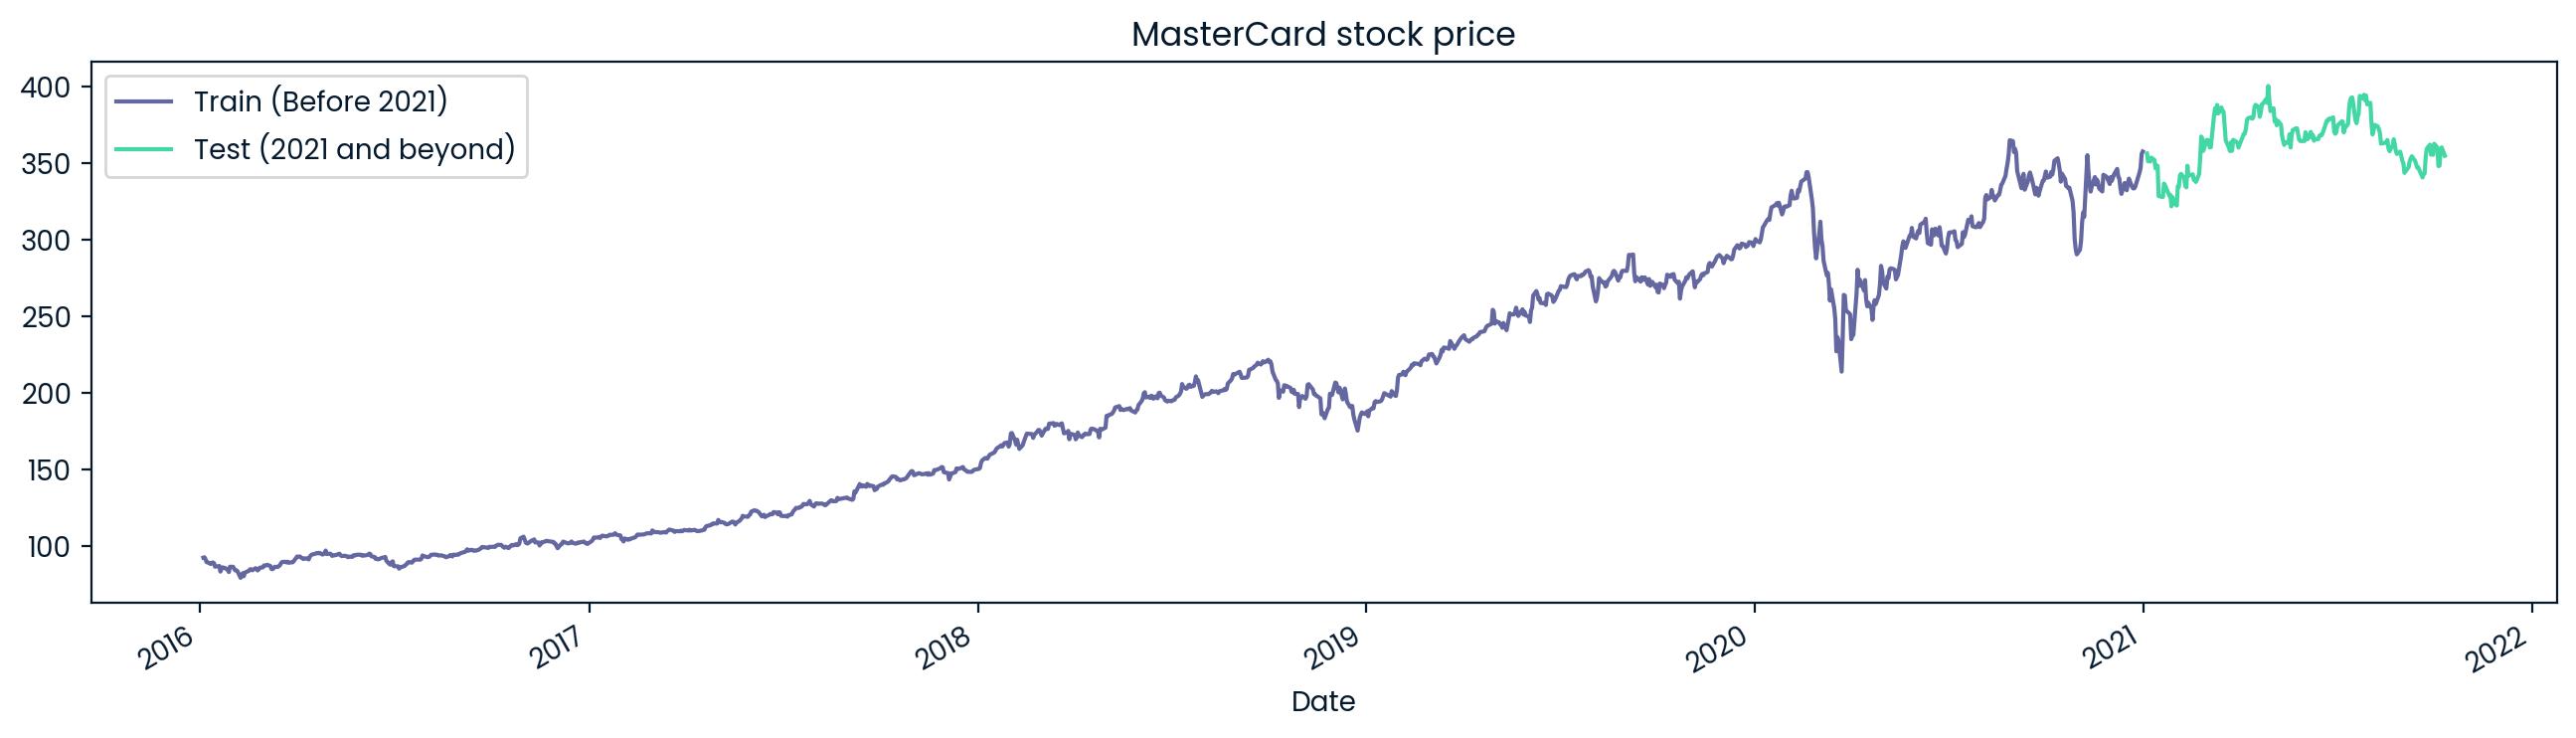

In [6]:
tstart = 2016
tend = 2020

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("MasterCard stock price")
    plt.show()

train_test_plot(dataset,tstart,tend)

## Data Preprocessing

Simple train test split function

In [7]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"].values
    test = dataset.loc[f"{tend+1}":, "High"].values
    return train, test

training_set, test_set = train_test_split(dataset, tstart, tend)

Normalizing the data using MinMaxScaler

In [8]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

Spliting a univariate sequence into samples

In [9]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

Reshaping X_train for efficient modelling

In [10]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

## LSTM Model

A simple LSTM model with a single hidden layer of LSTM and an output layer.

In [11]:
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))

# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

2024-07-04 21:23:02.621237: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125)               63500     
                                                                 
 dense (Dense)               (None, 1)                 126       
                                                                 
Total params: 63,626
Trainable params: 63,626
Non-trainable params: 0
_________________________________________________________________


Training with 50 epochs and 32 batch size.

In [12]:
# Fitting to the training set
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
38/38 [==============================] - 3s 48ms/step - loss: 0.0142
Epoch 2/50
38/38 [==============================] - 2s 46ms/step - loss: 0.0027
Epoch 3/50
38/38 [==============================] - 2s 48ms/step - loss: 0.0020
Epoch 4/50
38/38 [==============================] - 2s 47ms/step - loss: 0.0019


## Results

First, transform, then split the dataset into samples, reshape it, predict, and inverse transform the predictions into standard form. 

In [13]:
dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

In [14]:
# Preparing X_test and predicting the prices
X_test, y_test = split_sequence(inputs, n_steps)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
predicted_stock_price = model_lstm.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y_test = sc.inverse_transform(y_test)

- `plot_predictions` function will plot a real versus predicted line chart
- `return_rmse` prints out the root mean square error (rmse) metric.


In [15]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))


Visualizing the results for LSTM

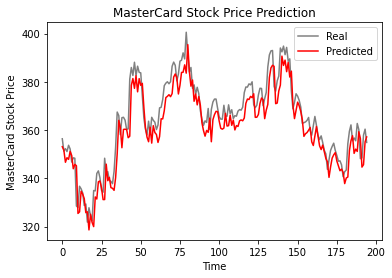

In [16]:
plot_predictions(y_test,predicted_stock_price)

The results look promising as the model got 6.70 rmse on the test dataset. 

In [17]:
return_rmse(y_test,predicted_stock_price)

The root mean squared error is 6.70.


### Saving Model

In [18]:
model_lstm.save("model/LSTM")

2022-04-05 07:51:03.494268: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model/LSTM/assets


INFO:tensorflow:Assets written to: model/LSTM/assets


## GRU Model 

The GRU architecture with similar structure and hyperparameters.

In [19]:
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the model
model_gru.compile(optimizer="RMSprop", loss="mse")

model_gru.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 125)               48000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 126       
Total params: 48,126
Trainable params: 48,126
Non-trainable params: 0
_________________________________________________________________


In [20]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32)


Epoch 1/50
38/38 [==============================] - 4s 70ms/step - loss: 0.0582
Epoch 2/50
38/38 [==============================] - 2s 65ms/step - loss: 0.0044
Epoch 3/50
38/38 [==============================] - 2s 67ms/step - loss: 0.0020
Epoch 4/50
38/38 [==============================] - 2s 65ms/step - loss: 0.0013
Epoch 5/50
38/38 [==============================] - 2s 65ms/step - loss: 9.4554e-04
Epoch 6/50
38/38 [==============================] - 2s 66ms/step - loss: 9.9860e-04
Epoch 7/50
38/38 [==============================] - 2s 65ms/step - loss: 6.1373e-04
Epoch 8/50
38/38 [==============================] - 2s 65ms/step - loss: 7.9382e-04
Epoch 9/50
38/38 [==============================] - 2s 65ms/step - loss: 7.8859e-04
Epoch 10/50
38/38 [==============================] - 2s 62ms/step - loss: 8.1784e-04
Epoch 11/50
38/38 [==============================] - 2s 62ms/step - loss: 5.6758e-04
Epoch 12/50
38/38 [==============================] - 2s 62ms/step - loss: 5.9090e-04
Epoch

## Results

In [21]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

The predicted line chart almost fits the actual values. 

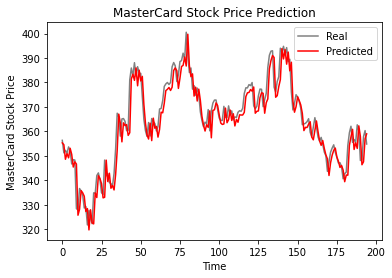

In [22]:
plot_predictions(y_test, GRU_predicted_stock_price)

GRU model got 5.50 rmse on the test dataset, which is an improvement from the LSTM model.  

In [23]:
return_rmse(y_test,GRU_predicted_stock_price)

The root mean squared error is 5.50.


### Save Model

In [24]:
model_gru.save('model/GRU')

INFO:tensorflow:Assets written to: model/GRU/assets


INFO:tensorflow:Assets written to: model/GRU/assets


In [29]:
# !zip -r project.zip \data \model RNN.png LSTM_GRU.ipynb

updating: RNN.png (deflated 8%)
updating: LSTM_GRU.ipynb (deflated 35%)
  adding: data/ (stored 0%)
  adding: data/Mastercard_stock_history.csv (deflated 60%)
  adding: data/Mastercard_stock_info.csv (deflated 53%)
  adding: data/NVidia_stock_history.csv (deflated 61%)
  adding: data/NVidia_stock_info.csv (deflated 51%)
  adding: model/ (stored 0%)
  adding: model/LSTM/ (stored 0%)
  adding: model/LSTM/variables/ (stored 0%)
  adding: model/LSTM/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: model/LSTM/variables/variables.index (deflated 56%)
  adding: model/LSTM/saved_model.pb (deflated 90%)
  adding: model/LSTM/assets/ (stored 0%)
  adding: model/GRU/ (stored 0%)
  adding: model/GRU/variables/ (stored 0%)
  adding: model/GRU/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: model/GRU/variables/variables.index (deflated 57%)
  adding: model/GRU/saved_model.pb (deflated 90%)
  adding: model/GRU/assets/ (stored 0%)
